In [1]:
# check GPU infomation
!nvidia-smi

Tue May  5 11:43:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#@title Download data and unzip the file
#@markdown Data source：https://www.kaggle.com/shanecandoit/dataset-of-bmode-fatty-liver-ultrasound-images
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://storage.googleapis.com/meso_patho/dataset-of-bmode-fatty-liver-ultrasound-images.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [3]:
#@title --import packages and modules
import numpy as np
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt

# tensorflow.keras
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input 和下面那行擇一，or Xception（但不是本次作業重點）
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model

Tensorflow version = 2.2.0-rc3


# 0 read data from MatLab format
https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html

In [4]:
# open .mat file
mat_file = 'data/dataset_liver_bmodes_steatosis_assessment_IJCARS.mat'
mat_contents = sio.loadmat(mat_file)
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [5]:
# get 'data' contents
data = mat_contents['data']
print("fields =", data.dtype, "\tshape =", data.shape)

fields = [('id', 'O'), ('class', 'O'), ('fat', 'O'), ('images', 'O')] 	shape = (1, 55)


In [6]:
# list all data
data_info = []
for i in range(data.shape[1]):
    idx = data['id'][0,i].item()
    cls = data['class'][0,i].item()
    fat = data['fat'][0,i].item()
    print(f"id: {idx} \t class: {cls}   fat: {fat}")

id: 1 	 class: 0   fat: 3
id: 2 	 class: 0   fat: 4
id: 3 	 class: 0   fat: 2
id: 4 	 class: 0   fat: 1
id: 5 	 class: 0   fat: 2
id: 6 	 class: 0   fat: 2
id: 7 	 class: 0   fat: 2
id: 8 	 class: 0   fat: 2
id: 9 	 class: 0   fat: 2
id: 10 	 class: 0   fat: 1
id: 11 	 class: 0   fat: 1
id: 12 	 class: 0   fat: 2
id: 13 	 class: 0   fat: 3
id: 14 	 class: 0   fat: 3
id: 15 	 class: 0   fat: 0
id: 16 	 class: 0   fat: 0
id: 17 	 class: 0   fat: 2
id: 18 	 class: 1   fat: 40
id: 19 	 class: 1   fat: 70
id: 20 	 class: 1   fat: 15
id: 21 	 class: 1   fat: 7
id: 22 	 class: 1   fat: 70
id: 23 	 class: 1   fat: 25
id: 24 	 class: 1   fat: 20
id: 25 	 class: 1   fat: 10
id: 26 	 class: 1   fat: 85
id: 27 	 class: 1   fat: 75
id: 28 	 class: 1   fat: 55
id: 29 	 class: 1   fat: 20
id: 30 	 class: 1   fat: 20
id: 31 	 class: 1   fat: 30
id: 32 	 class: 1   fat: 55
id: 33 	 class: 1   fat: 40
id: 34 	 class: 1   fat: 70
id: 35 	 class: 1   fat: 70
id: 36 	 class: 1   fat: 80
id: 37 	 class: 1  

data['images'] shape = (10, 434, 636)


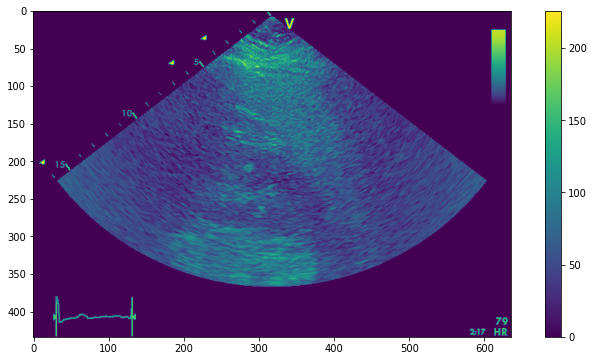

In [10]:
# 10 images per patient
i = 33
print("data['images'] shape =", data[0,i]['images'].shape)
# plot one image
fig = plt.figure(figsize=(12,6))
plt.imshow(data[0,i]['images'][0])
plt.colorbar()
plt.show()

## prepare train/valid set for machine learning

In [11]:
# range choise test patient ids (1-55 take 10) and generate training patient ids
valid_ids = np.random.randint(data.shape[1], size=10) + 1
print("valid_ids =", valid_ids, "len =", len(valid_ids))
train_ids = [ i for i in range(1,data.shape[1]+1) if i not in valid_ids ]
print("train_ids =", train_ids, "len =", len(train_ids))

valid_ids = [ 7 23 45 53  1 21 35 32 26  2] len = 10
train_ids = [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55] len = 45


In [12]:
# process data to X and y
def proc_data(data_ids):
    X_list = []
    y_list = []

    # process data one by one
    for i in data_ids:
        i = i - 1  # id to index
        # n images in this patient
        n_img = data[0,i]['images'].shape[0]
        # get images
        X = [ data[0,i]['images'][j] for j in range(n_img) ]  # n image list
        X = [ x[50:350, 80:-80] for x in X ]  # crop image
        X_list.extend(X)
        # 'fat' as y (steatosis %)
        y = [ data[0,i]['fat'].item()/100 for n in range(n_img) ]  # convert to percentage [0.0-1.0], and repeat n times
        y_list.extend(y)

    X_arr = np.stack(X_list)
    y_arr = np.stack(y_list)
    return X_arr, y_arr

# training set
X_train, y_train = proc_data(train_ids)
X_train = np.repeat(X_train[:, :, :, np.newaxis], 3, axis=3)  # add color channel at last
print("X_train shape =", X_train.shape, "   y_train shape =", y_train.shape)
print("y_train ex:", y_train[:30])

# valid set
X_valid, y_valid = proc_data(valid_ids)
X_valid = np.repeat(X_valid[:, :, :, np.newaxis], 3, axis=3)  # add color channel at last
print("X_valid shape =", X_valid.shape, "    y_valid shape =", y_valid.shape)
print("y_valid ex:", y_valid[:30])

X_train shape = (450, 300, 476, 3)    y_train shape = (450,)
y_train ex: [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]
X_valid shape = (100, 300, 476, 3)     y_valid shape = (100,)
y_valid ex: [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2 ]


# 1 DataGenerator

In [94]:
#@title data augmentation settings

shear_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.15 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.15 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 5 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}

batch_size = 12

train_datagen = ImageDataGenerator(
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip, 
    preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow(X_train, y_train, 
                                     batch_size=batch_size, 
                                     shuffle=True)
train_steps_per_epoch = np.ceil(len(y_train)/batch_size)
print("train_steps_per_epoch =", train_steps_per_epoch)

# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(X_valid, y_valid, 
                                     batch_size=batch_size, 
                                     shuffle=False)
test_steps_per_epoch = np.ceil(len(y_valid)/batch_size)
print("test_steps_per_epoch =", test_steps_per_epoch)

train_steps_per_epoch = 38.0
test_steps_per_epoch = 9.0


X_batch shape: (12, 300, 476, 3) 	y_batch shape: (12,)


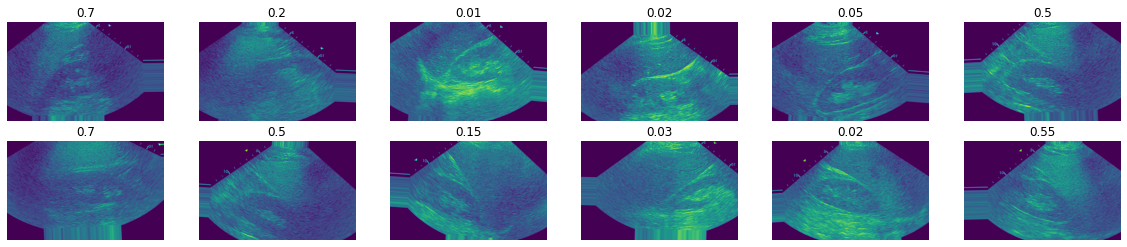

In [95]:
#@title Plot some training data from train_generator
X_batch, y_batch = train_generator.next()
print("X_batch shape:", X_batch.shape, "\ty_batch shape:", y_batch.shape)

fig=plt.figure(figsize=(20, 4))
columns = 6
rows = 2
for i in range(1, columns*rows +1):
    img = X_batch[i-1]
    fig.add_subplot(rows, columns, i)
    plt.title(y_batch[i-1])
    plt.axis('off')
    plt.imshow(img[:,:,0])  # show single channel
plt.show()

# 2 Model

In [96]:
# Extract features with pre-trained base_model
# https://keras.io/applications/
# https://keras.io/activations/
K.clear_session()

# base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])
base_model.trainable = False  # freeze all layers of base_model

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
x = Dense(10, kernel_initializer='normal', activation='tanh')(x)
outputs = Dense(1, kernel_initializer='normal')(x)  # regression final layer without any activation

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 476, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 482, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 238, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 238, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

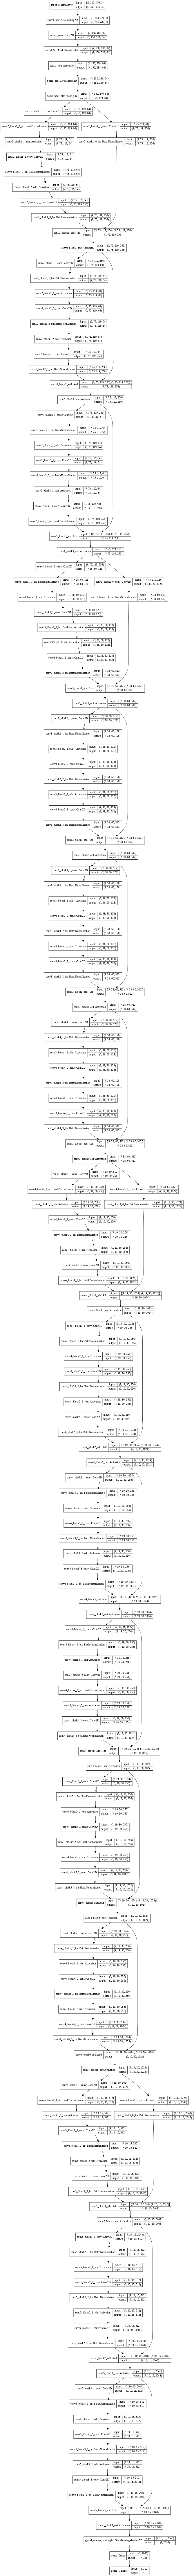

In [97]:
#@title plot model
plot_model(model, to_file="model_plot.png", show_shapes=True, dpi=60)

## compile model
for regression task

In [0]:
# compile model
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

# 3 Training

In [99]:
#@title Run training
EPOCHES = 50#@param {type:"number"} 
#訓練時至少10到20去看

history = model.fit(
    train_generator, 
    steps_per_epoch=train_steps_per_epoch, 
    epochs=EPOCHES, 
    validation_data=test_generator, 
    validation_steps=test_steps_per_epoch)

Epoch 1/50
38/38 [==============================] - 14s 367ms/step - loss: 0.0718 - mae: 0.2260 - val_loss: 0.0811 - val_mae: 0.2382
Epoch 2/50
38/38 [==============================] - 13s 346ms/step - loss: 0.0550 - mae: 0.1889 - val_loss: 0.0751 - val_mae: 0.2255
Epoch 3/50
38/38 [==============================] - 13s 342ms/step - loss: 0.0444 - mae: 0.1688 - val_loss: 0.0561 - val_mae: 0.2026
Epoch 4/50
38/38 [==============================] - 13s 340ms/step - loss: 0.0402 - mae: 0.1571 - val_loss: 0.0523 - val_mae: 0.2027
Epoch 5/50
38/38 [==============================] - 13s 343ms/step - loss: 0.0376 - mae: 0.1497 - val_loss: 0.0467 - val_mae: 0.1893
Epoch 6/50
38/38 [==============================] - 13s 340ms/step - loss: 0.0279 - mae: 0.1291 - val_loss: 0.0458 - val_mae: 0.1857
Epoch 7/50
38/38 [==============================] - 13s 341ms/step - loss: 0.0302 - mae: 0.1361 - val_loss: 0.0697 - val_mae: 0.2111
Epoch 8/50
38/38 [==============================] - 13s 341ms/step - 

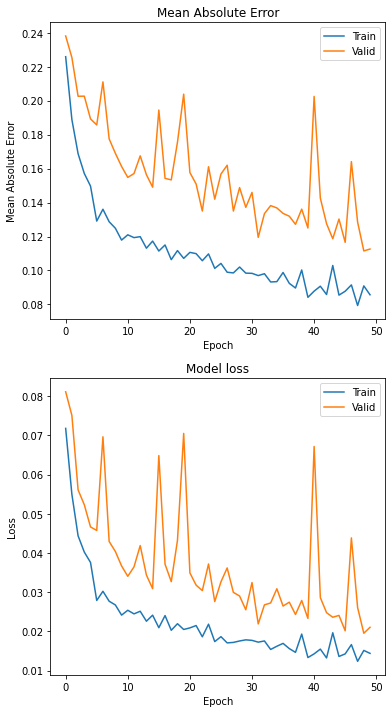

In [100]:
# Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('Mean Absolute Error')
ax1.set(ylabel='Mean Absolute Error', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

# 4 Evaluation all data
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [101]:
# test set (all data)
X_test, y_test = proc_data(range(1, data.shape[1]+1))
X_test = np.repeat(X_test[:, :, :, np.newaxis], 3, axis=3)  # add color channel at last
print("X_test shape =", X_test.shape, "    y_test shape =", y_test.shape)
print("y_test ex:", y_test[:30])

# test_generator
test_generator = test_datagen.flow(X_test, y_test, 
                                     batch_size=batch_size, 
                                     shuffle=False)
test_steps_per_epoch = np.ceil(len(y_test)/batch_size)

X_test shape = (550, 300, 476, 3)     y_test shape = (550,)
y_test ex: [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]


In [102]:
# prediction
y_pred = model.predict(test_generator,
                       steps=test_steps_per_epoch, 
                       verbose=1)
y_pred = y_pred.reshape(-1,)

y_true = y_test
print("y_true shape:", y_true.shape, "\ty_pred shape:", y_pred.shape)
print("y_true =", y_true[:10])
print("y_pred =", y_pred[:10])

46/46 [==============================] - 3s 69ms/step
y_true shape: (550,) 	y_pred shape: (550,)
y_true = [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
y_pred = [0.03981446 0.03768697 0.036977   0.03363779 0.03599393 0.04745033
 0.03795906 0.02902107 0.038002   0.03683098]


In [103]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = median_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print("Median Absolute Error (MAE) =", mae)
print("Root Mean Square Error (RMSE) =", rmse)
print("R² score =", r2)

Median Absolute Error (MAE) = 0.054044527411460874
Root Mean Square Error (RMSE) = 0.10634971483590025
R² score = 0.8447650160655711


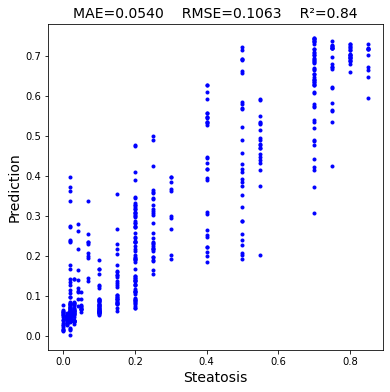

In [104]:
#@title prediction-steatosis scatter plot
fig=plt.figure(figsize=(6, 6))
plt.title("MAE={:.4f}    RMSE={:.4f}    R²={:.2f}".format(mae, rmse, r2), fontsize=14)
plt.plot(y_true, y_pred, 'b.')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('Steatosis', fontsize=14)
plt.ylabel('Prediction', fontsize=14)
plt.savefig('prediction-steatosis.png', dpi=72)  # <-- save plot
plt.show()

In [25]:
@#title Save model
model.save('my_model.h5')

SyntaxError: ignored